In [273]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


#### 1. Load the .csv file into a variable (here df)

In [274]:
df = pd.read_csv('churn.csv')
df.head()  # shows the first 5 rows of df

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


by `.info()` we can see the information about our dataset. pay attension to NULL items and Dtype

In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

#### 2. Delete the un-nessesory columns with drop function
`inplace=True` will replace the result in the variable (here df).

set `axis=0` will remove row and `axis=1` removes column

`errors="ignore"` will ignore the error if the was no such columns or rows to delete

`.unique()` print out all the unique items in an specified column

In [276]:
df['Churn?'].unique()

array(['False.', 'True.'], dtype=object)

#### 3. there should be NO space or blank in the names. so we should replace them with under score. following command will replace it in only `State` column. 
`regex=True` is regular expression and is just an advanced feature for search and replace 


In [277]:
df['State'].replace(to_replace=' ',value='_',regex=True, inplace=True)

following command will show first 10 items of `.unique()`

In [278]:
df['State'].unique()[0:10]

array(['KS', 'OH', 'NJ', 'OK', 'AL', 'MA', 'MO', 'LA', 'WV', 'IN'],
      dtype=object)

#### 4. replace the space and blanks in the name of all columns (if any)

In [279]:
df.columns = df.columns.str.replace(pat=' ', repl="_")
df.head()

,State,Account_Length,Area_Code,Phone,Int'l_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,...,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


#### 5. We should do some steps to find the missing data and replace them with `0`

#### a. see the data type of all columns
if the data-type is `object` it means that it contains more than one data type. so it is possible to have some sort of missing 
data or irrelevant data there.

NOTE: XGBOOST only allows int, float or boolean. other data types should be converted into these numeric types.

In [280]:
df.dtypes

State              object
Account_Length      int64
Area_Code           int64
Phone              object
Int'l_Plan         object
VMail_Plan         object
VMail_Message       int64
Day_Mins          float64
Day_Calls           int64
Day_Charge        float64
Eve_Mins          float64
Eve_Calls           int64
Eve_Charge        float64
Night_Mins        float64
Night_Calls         int64
Night_Charge      float64
Intl_Mins         float64
Intl_Calls          int64
Intl_Charge       float64
CustServ_Calls      int64
Churn?             object
dtype: object

#### b. to check the content of a column we can use `.unique()` to see all the contents. This check should be done for all `object` type columns. here we only do if for `Int'l_Plan` column.

In [281]:
df["Int'l_Plan"].unique()

array(['no', 'yes'], dtype=object)

#### c. if a column data-type is `object` but we are sure that it should contain only numerical data-type, we can use following command. if it gave error you can find the place of irrelevant data or spaces. (here `Day_Mins` is an instace column name.)
the error will be some thing like below:

`ValueError: Unable to parse string " " at position 2234`

In [282]:
df['Day_Mins'] = pd.to_numeric(df['Day_Mins'])

#### d. to find the exact location and number of a special charector use following commands:

`df.loc[]` will give us all the places which `df['State']=="KS"` occures


In [283]:
df.loc[df['State']=="KS"]


,State,Account_Length,Area_Code,Phone,Int'l_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,...,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
179,KS,70,408,411-4582,no,no,0,232.1,122,39.46,...,112,24.85,201.2,112,9.05,0.0,0,0.00,3,False.
258,KS,92,408,386-4170,yes,no,0,62.6,111,10.64,...,126,15.35,221.7,80,9.98,10.4,2,2.81,1,True.
287,KS,137,408,352-8202,no,no,0,205.9,88,35.00,...,86,17.79,289.9,84,13.05,14.5,4,3.92,2,False.
368,KS,132,415,369-3214,no,no,0,83.4,110,14.18,...,137,19.74,146.7,114,6.60,7.6,5,2.05,1,False.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3217,KS,164,510,394-3051,no,yes,30,238.8,100,40.60,...,121,19.55,206.3,66,9.28,13.2,8,3.56,1,False.
3244,KS,101,415,347-9968,no,no,0,231.3,87,39.32,...,88,19.10,214.6,69,9.66,7.2,7,1.94,1,False.
3253,KS,127,415,354-6810,no,yes,24,154.8,69,26.32,...,105,15.06,207.6,102,9.34,9.0,4,2.43,1,False.
3285,KS,57,415,362-2067,no,no,0,158.1,117,26.88,...,149,9.79,182.4,92,8.21,11.8,7,3.19,0,False.


In [284]:
len(df.loc[df['State']=="KS"])

70

#### e. To replace a column item, we can use following command:

here `KS` will be replaced with `KT` in `State` column

In [285]:
df.loc[(df['State']=="KS"), 'State']="KT"

In [286]:
df.loc[df["State"]=="KT"]

,State,Account_Length,Area_Code,Phone,Int'l_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,...,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Churn?
0,KT,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
179,KT,70,408,411-4582,no,no,0,232.1,122,39.46,...,112,24.85,201.2,112,9.05,0.0,0,0.00,3,False.
258,KT,92,408,386-4170,yes,no,0,62.6,111,10.64,...,126,15.35,221.7,80,9.98,10.4,2,2.81,1,True.
287,KT,137,408,352-8202,no,no,0,205.9,88,35.00,...,86,17.79,289.9,84,13.05,14.5,4,3.92,2,False.
368,KT,132,415,369-3214,no,no,0,83.4,110,14.18,...,137,19.74,146.7,114,6.60,7.6,5,2.05,1,False.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3217,KT,164,510,394-3051,no,yes,30,238.8,100,40.60,...,121,19.55,206.3,66,9.28,13.2,8,3.56,1,False.
3244,KT,101,415,347-9968,no,no,0,231.3,87,39.32,...,88,19.10,214.6,69,9.66,7.2,7,1.94,1,False.
3253,KT,127,415,354-6810,no,yes,24,154.8,69,26.32,...,105,15.06,207.6,102,9.34,9.0,4,2.43,1,False.
3285,KT,57,415,362-2067,no,no,0,158.1,117,26.88,...,149,9.79,182.4,92,8.21,11.8,7,3.19,0,False.


We can replace a charector in whole dataset (not only a spesific column) by following command:

In [287]:
df.replace(" ","_",regex=True, inplace=True)
df.head()

,State,Account_Length,Area_Code,Phone,Int'l_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,...,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Churn?
0,KT,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


#### 6. To divide the dataset to `X` & `y` do the following steps:

a. make `X` by dropping the one column which should be predicted in future:

In [288]:
X = df.drop(columns="Churn?")
X.head()

,State,Account_Length,Area_Code,Phone,Int'l_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls
0,KT,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


b. make `y` by copping the column which will be predicted in future

In [289]:
X.replace("no",0,regex=True, inplace=True)
X.replace("yes",1,regex=True, inplace=True)

In [290]:
X.head()

,State,Account_Length,Area_Code,Phone,Int'l_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls
0,KT,128,415,382-4657,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,OH,84,408,375-9999,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,OK,75,415,330-6626,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [291]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account_Length  3333 non-null   int64  
 2   Area_Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l_Plan      3333 non-null   int64  
 5   VMail_Plan      3333 non-null   int64  
 6   VMail_Message   3333 non-null   int64  
 7   Day_Mins        3333 non-null   float64
 8   Day_Calls       3333 non-null   int64  
 9   Day_Charge      3333 non-null   float64
 10  Eve_Mins        3333 non-null   float64
 11  Eve_Calls       3333 non-null   int64  
 12  Eve_Charge      3333 non-null   float64
 13  Night_Mins      3333 non-null   float64
 14  Night_Calls     3333 non-null   int64  
 15  Night_Charge    3333 non-null   float64
 16  Intl_Mins       3333 non-null   float64
 17  Intl_Calls      3333 non-null   i

In [292]:
y = df['Churn?']
y.replace("False.",0,regex=True, inplace=True)
y.replace("True.",1,regex=True, inplace=True)
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Churn?, dtype: int64

In [293]:
from sklearn.compose import ColumnTransformer

#### 7.To use `make_column_transformer` we should categorize the features. below you can see 4 different features. each one is a list which contains the columns name from dataset.

In [294]:
numeric_feats = ["VMail_Message", "Day_Mins", "Day_Calls", "Day_Charge", "Eve_Mins", "Eve_Calls","Eve_Charge", "Night_Mins", "Night_Calls", "Night_Charge", "Intl_Mins", "Intl_Calls", "Intl_Charge", "CustServ_Calls"]  # apply scaling
categorical_feats = ["State", "Area_Code"]  # apply one-hot encoding
passthrough_feats = ["Int'l_Plan", "VMail_Plan"]  # do not apply any transformation
drop_feats = ["Account_Length", "Phone"]  # do not include these features

In [295]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

#### make_coolum_tranformer takes a subroutin and a feature (which we create it above)

In [296]:
from sklearn.compose import make_column_transformer

ct = make_column_transformer(    
    (StandardScaler(), numeric_feats),  # scaling on numeric features
    ("passthrough", passthrough_feats),  # no transformations on the binary features    
    (OneHotEncoder(), categorical_feats),  # OHE on categorical features
    ("drop", drop_feats),  # drop the drop features
)

In [297]:
ct          # Column Transformer

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['VMail_Message', 'Day_Mins', 'Day_Calls',
                                  'Day_Charge', 'Eve_Mins', 'Eve_Calls',
                                  'Eve_Charge', 'Night_Mins', 'Night_Calls',
                                  'Night_Charge', 'Intl_Mins', 'Intl_Calls',
                                  'Intl_Charge', 'CustServ_Calls']),
                                ('passthrough', 'passthrough',
                                 ["Int'l_Plan", 'VMail_Plan']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['State', 'Area_Code']),
                                ('drop', 'drop', ['Account_Length', 'Phone'])])

#### by using `fit_transform()` we will apply column transformer.

In [298]:
X_encoded = ct.fit_transform(X)
type(X_encoded)

scipy.sparse._csr.csr_matrix

#### by using `.toarray()` we can see the conteny of thid new encoded X file.

In [299]:
X_encoded = X_encoded.toarray() # type: ignore

#### Here we have a problem: the xencoded, has no column name. we should make it maually for that to make it like a dataframe:

the first feature was `numeric_feats` so the name and the number of columns remain the same.
but for the `categorical_feats` the name shall be created and the number of columns will increase. 
for the `passthrough_feats` every thing remains the same. 
the drop part will be omitted. 

so see the next commend to make a name list for columns:

#### 8. Now it is time to split the data into `test` and `train`. but it is a must to have the same ratio of 

In [300]:
ct.named_transformers_

{'standardscaler': StandardScaler(),
 'passthrough': 'passthrough',
 'onehotencoder': OneHotEncoder(),
 'drop': 'drop'}

In [301]:
column_names = (
    numeric_feats
    +ct.named_transformers_["onehotencoder"].get_feature_names_out().tolist()   #  "onehotencoder" is the automatic name which was created in make_column_transformer command according to OneHotEncoder(). it is actiually the lower case of the OneHotEncoder.
    +passthrough_feats
)

In [302]:
column_names, len(column_names)

(['VMail_Message',
  'Day_Mins',
  'Day_Calls',
  'Day_Charge',
  'Eve_Mins',
  'Eve_Calls',
  'Eve_Charge',
  'Night_Mins',
  'Night_Calls',
  'Night_Charge',
  'Intl_Mins',
  'Intl_Calls',
  'Intl_Charge',
  'CustServ_Calls',
  'State_AK',
  'State_AL',
  'State_AR',
  'State_AZ',
  'State_CA',
  'State_CO',
  'State_CT',
  'State_DC',
  'State_DE',
  'State_FL',
  'State_GA',
  'State_HI',
  'State_IA',
  'State_ID',
  'State_IL',
  'State_IN',
  'State_KT',
  'State_KY',
  'State_LA',
  'State_MA',
  'State_MD',
  'State_ME',
  'State_MI',
  'State_MN',
  'State_MO',
  'State_MS',
  'State_MT',
  'State_NC',
  'State_ND',
  'State_NE',
  'State_NH',
  'State_NJ',
  'State_NM',
  'State_NV',
  'State_NY',
  'State_OH',
  'State_OK',
  'State_OR',
  'State_PA',
  'State_RI',
  'State_SC',
  'State_SD',
  'State_TN',
  'State_TX',
  'State_UT',
  'State_VA',
  'State_VT',
  'State_WA',
  'State_WI',
  'State_WV',
  'State_WY',
  'Area_Code_408',
  'Area_Code_415',
  'Area_Code_510',
 

#### As we have column names and data, we can visualize the dataframe as below:

In [303]:
X_encoded = pd.DataFrame(X_encoded, columns=column_names)

In [304]:
sum(y)/len(y)

0.14491449144914492

#### as y is zeros and ones, the some of y indicates the some of ones. we need above ratio remains the same in test and train sets So we should use `stratify=y` in following command:

In [305]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y,test_size=0.2)

#### as you see in following command, stratify=y made the ratio in test result remain the same as main dataset.

In [306]:
sum(y_test)/len(y_test)

0.1454272863568216

#### in following command, we will make a XGBClassifier instance

early_stopping_rounds, indicated the number of runs which no progress is gained before stopping the job.

In [307]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',early_stopping_rounds=10, eval_metric='aucpr')

#### `.fit()` will apply the XGBClassifier on the dataFrame

In [308]:
clf_xgb.fit(X_train,
            y_train,
            verbose = True,
            eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.80003
[1]	validation_0-aucpr:0.83627
[2]	validation_0-aucpr:0.83734
[3]	validation_0-aucpr:0.83575
[4]	validation_0-aucpr:0.84316
[5]	validation_0-aucpr:0.83427
[6]	validation_0-aucpr:0.83872
[7]	validation_0-aucpr:0.85118
[8]	validation_0-aucpr:0.85157
[9]	validation_0-aucpr:0.85845
[10]	validation_0-aucpr:0.86436
[11]	validation_0-aucpr:0.86161
[12]	validation_0-aucpr:0.86491
[13]	validation_0-aucpr:0.86672
[14]	validation_0-aucpr:0.86188
[15]	validation_0-aucpr:0.86276
[16]	validation_0-aucpr:0.86286
[17]	validation_0-aucpr:0.86176
[18]	validation_0-aucpr:0.86134
[19]	validation_0-aucpr:0.86045
[20]	validation_0-aucpr:0.85956
[21]	validation_0-aucpr:0.85974
[22]	validation_0-aucpr:0.85876


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

#### next command will create a prediction on X_test and put it in y_pred

In [309]:
y_pred = clf_xgb.predict(X_test)

#### first we will create a confusion Matrix to see the result and after that with `ConfusionMatrixDisplay().plot` we will show it

In [310]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

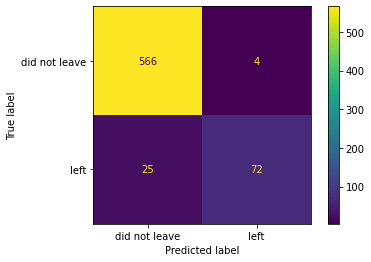

In [311]:
ConfusionMatrixDisplay(cm,display_labels=['did not leave', 'left']).plot()

#### To tune the results we can define a param_grid which accepts some ranges. and find the optimal parameters with it:

In [312]:
param_grid = {
    'max_depth': [3,4,5],
    'learning_rate':[0.1, 0.01, 0.05],
    'gamma':[0,0.25,1.0],
    'reg_lambda': [0,1.0, 10.0],
    'scale_pos_weight':[1,3,5]
}

#### `GridSearchCV` will report the optimal values within this ranges:

In [313]:
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                subsample=0.9,
                                colsample_bytree=0.5,
                                early_stopping_rounds=10,
                                eval_metric='auc',),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=0,
    n_jobs=10,
    cv=3,
)

In [314]:
optimal_params.fit(X_train,
                   y_train,
                   eval_set=[(X_test,y_test)],
                   verbose=False)
print(optimal_params.best_params_)

{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 0, 'scale_pos_weight': 3}


#### after first RUN. we decide to change the value to find better ones. for example the range for the 'max_depth' was 'max_depth': [3,4,5]. as the reported optimum value is 'max_depth': 5 and 5 is the upper bundry we have to extend the range to 'max_depth': [5,6,7] to check for better values. 

In [324]:
param_grid = {
    'max_depth': [5,6,7],
    'learning_rate':[0.1, 0.2, 0.3],
    'gamma':[0.25],
    'reg_lambda': [0],
    'scale_pos_weight':[3]
}

In [325]:
optimal_params.fit(X_train,
                   y_train,
                   eval_set=[(X_test,y_test)],
                   verbose=False)
print(optimal_params.best_params_)

{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 0, 'scale_pos_weight': 3}


In [445]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            early_stopping_rounds=10,
                            eval_metric='aucpr',
                            gamma=0.25,
                            learning_rate=0.1,
                            max_depth=5,
                            reg_lambda=0,
                            scale_pos_weight=3,
                            subsample=0.9,
                            colsample_bytree=0.5
                            )
clf_xgb.fit(X_train,
            y_train,
            verbose = True,
            eval_set=[(X_test, y_test)])


[0]	validation_0-aucpr:0.77541
[1]	validation_0-aucpr:0.76565
[2]	validation_0-aucpr:0.76139
[3]	validation_0-aucpr:0.77806
[4]	validation_0-aucpr:0.81034
[5]	validation_0-aucpr:0.82335
[6]	validation_0-aucpr:0.82658
[7]	validation_0-aucpr:0.81053
[8]	validation_0-aucpr:0.81358
[9]	validation_0-aucpr:0.83897
[10]	validation_0-aucpr:0.83976
[11]	validation_0-aucpr:0.84935
[12]	validation_0-aucpr:0.85155
[13]	validation_0-aucpr:0.85400
[14]	validation_0-aucpr:0.85197
[15]	validation_0-aucpr:0.84844
[16]	validation_0-aucpr:0.85178
[17]	validation_0-aucpr:0.84329
[18]	validation_0-aucpr:0.84534
[19]	validation_0-aucpr:0.84864
[20]	validation_0-aucpr:0.84882
[21]	validation_0-aucpr:0.84773
[22]	validation_0-aucpr:0.85421
[23]	validation_0-aucpr:0.85221
[24]	validation_0-aucpr:0.85408
[25]	validation_0-aucpr:0.85631
[26]	validation_0-aucpr:0.85563
[27]	validation_0-aucpr:0.85380
[28]	validation_0-aucpr:0.85756
[29]	validation_0-aucpr:0.85836
[30]	validation_0-aucpr:0.85571
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.25, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

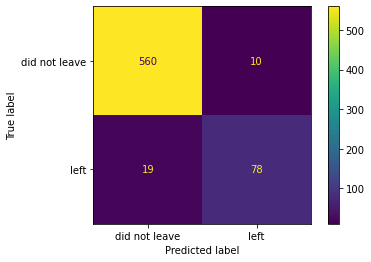

In [446]:
y_pred = clf_xgb.predict(X_test)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
ConfusionMatrixDisplay(cm,display_labels=['did not leave', 'left']).plot()

In [447]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            gamma=0,
                            learning_rate=0.1,
                            max_depth=4,
                            reg_lambda=0,
                            scale_pos_weight=5,
                            subsample=0.9,
                            colsample_bytree=0.5,
                            n_estimators=1
                            )
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [448]:
bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: '%importance_type, bst.get_score(importance_type=importance_type))

weight:  {'Day_Charge': 5.0, 'Eve_Mins': 5.0, 'Night_Mins': 1.0, 'Intl_Calls': 1.0, 'CustServ_Calls': 1.0, 'State_AK': 2.0}
gain:  {'Day_Charge': 135.16571044921875, 'Eve_Mins': 50.016944885253906, 'Night_Mins': 4.694122314453125, 'Intl_Calls': 65.8717041015625, 'CustServ_Calls': 674.133544921875, 'State_AK': 210.86572265625}
cover:  {'Day_Charge': 357.1000061035156, 'Eve_Mins': 107.6500015258789, 'Night_Mins': 92.0, 'Intl_Calls': 81.5, 'CustServ_Calls': 646.75, 'State_AK': 295.0}
total_gain:  {'Day_Charge': 675.8285522460938, 'Eve_Mins': 250.084716796875, 'Night_Mins': 4.694122314453125, 'Intl_Calls': 65.8717041015625, 'CustServ_Calls': 674.133544921875, 'State_AK': 421.7314453125}
total_cover:  {'Day_Charge': 1785.5, 'Eve_Mins': 538.25, 'Night_Mins': 92.0, 'Intl_Calls': 81.5, 'CustServ_Calls': 646.75, 'State_AK': 590.0}


In [449]:
node_params = {'shape':'box',
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'}
leaf_params = {'shape':'box',
               'style': 'filled',
               'fillcolor': '#e48038'}

In [450]:
graph_data = xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)

In [451]:
graph_data.view(filename="xgboost_tree_customer_churn")

'xgboost_tree_customer_churn.pdf'

/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/farzad/snap/code/common/.cache/gio-modules/libgiolibproxy.so

(process:15547): Gtk-WARNING **: 07:56:46.707: Locale not supported by C library.
	Using the fallback 'C' locale.
/home/farzad/snap/code/common/.cache/gio-modules/libgiolibproxy.so: cannot open shared object file: Permission denied
Failed to load module: /home/farzad/snap/code/common/.cache/gio-modules/libgiolibproxy.so

(evince:15547): Gtk-WARNING **: 07:56:46.731: Theme parsing error: gtk-keys.css:1:0: Failed to import: Error opening file /snap/code/126/usr/share/themes/Default/gtk-3.0/gtk-keys.css: Permission denied
Gtk-Message: 07:56:46.732: Failed to load module "canberra-gtk-module"
Gtk-Message: 07:56:46.732: Failed to load module "canberra-gtk-module"
/home/farzad/snap/code/common/.cache/gio-modules/libdconfsettings.so: cannot open shared object fil